# Library imports

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.dae import *

from scipy.integrate import odeint, solve_ivp
from scipy.interpolate import CubicSpline
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Helper functions

In [2]:
# This simulates the ground truth model detailed in the methods section.
# The physics and assumptions of this model are detailed in the paper

def combined_ode_system(t,y,y0_g):
    
    Xv, Xd, Cg, Cm, Cc = y
    
    mu_g_max = ((0.74)* 10**-0.75)
    Kg = (0.2)* 10**2
    
    mu_c_death = (0.06)* 10**0.25
    Kc = (1)* 10**1.5
    
    k_d = (0.001)* 10**1
    
    Y_xg = (0.052)* 10**0
    
    m_k = (0.06)* 10**1.5
    k_c_maint = (0.03)* 10**3    
    
    Y_mx = (20)* 10**-1
    beta = (5)* 10**-0.75
    
    kc = 10**1.5
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    mu_g = 2*((mu_g_max*Cg)/(Kg + Cg))
    
    Xm = Y_xg*y0_g
    
    log_x = (1-(Xv/Xm))
    
    mu_growth = mu_g*log_x
    
    mu_death = k_d + ((mu_c_death*Cc)/(Kc + Cc))/2
    
    maint_gc = (m_k*Cc)/(k_c_maint + Cc)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    
    dXvdt = (mu_growth - mu_death)*Xv 
    
    dXddt = mu_death*Xv
    
    dCgdt = -1*(mu_growth/Y_xg)*Xv - maint_gc*Xv
    
    dCmdt = Y_mx*(mu_growth + beta)*Xv*(Cc/(Cc + kc))
    
    dCcdt = -1*dCmdt
    
    return [dXvdt, dXddt, dCgdt, dCmdt, dCcdt]

In [3]:
y0 = np.array([0.1, 0.0, 82, 0, 20])
tspan = (0, 72)

sol = solve_ivp(combined_ode_system, tspan, y0, args = tuple([y0[2]]), method = "Radau")

y_true = np.copy(sol.y)

y_act = sol.y
y_act[0,:] = y_act[0,:] + y_act[1,:]
y_act1 = np.delete(y_act, 1, axis = 0)

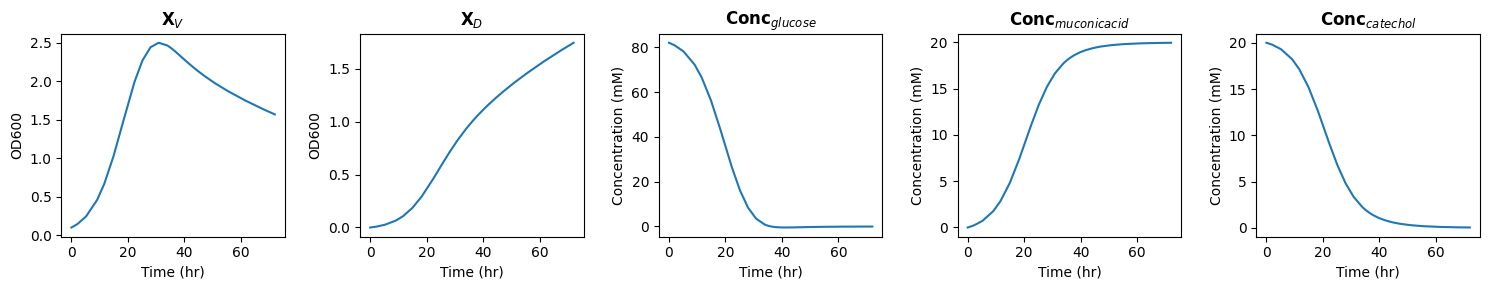

In [4]:
fig, axs = plt.subplots(1,5, figsize = (15,3))
ax = axs.ravel()

Name = ["X$_V$","X$_D$", "Conc$_{glucose}$", "Conc$_{muconic acid}$", "Conc$_{catechol}$"]
ylabels = ["OD600", "OD600", "Concentration (mM)", "Concentration (mM)", "Concentration (mM)"]

for i in range(len(y_true)):
    ax[i].plot(sol.t, y_true[i,:])
    ax[i].set_xlabel("Time (hr)")
    ax[i].set_ylabel(ylabels[i])
    ax[i].set_title(Name[i], fontweight = "bold")

plt.tight_layout()

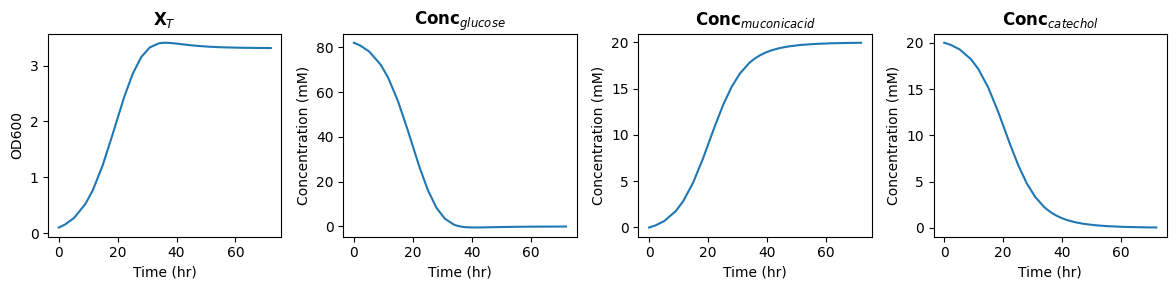

In [5]:
fig, axs = plt.subplots(1, 4, figsize = (12, 3))
ax = axs.ravel()
Name = ["X$_T$", "Conc$_{glucose}$", "Conc$_{muconic acid}$", "Conc$_{catechol}$"]
ylabels = ["OD600", "Concentration (mM)", "Concentration (mM)", "Concentration (mM)"]

for i in range(len(y_act1)):
    ax[i].plot(sol.t, y_act1[i,:])
    ax[i].set_xlabel("Time (hr)")
    ax[i].set_ylabel(ylabels[i])
    ax[i].set_title(Name[i], fontweight = "bold")

plt.tight_layout()

In [6]:
def syn_data_generation(num_points, file_name):
    
    # This function takes in the number point and a file name which has
    # different initial conditions of the batch system. This generates 
    # the training data outlined in the paper. 72-hour batch bioprocess.
    # This return the training data 
    
    dir_n = "Initial_conditions\\" + file_name
    
    Init_cond = np.loadtxt(dir_n)

    sol_dict = {}
    mu_dict = {}

    for i in range(len(Init_cond)):
        
        y0 = Init_cond[i,:]
        tspan = (0, 72)
        teval = np.linspace(tspan[0], tspan[1], num_points)
        
        sol = solve_ivp(combined_ode_system, tspan, y0, args = tuple([y0[2]]), method = "Radau", t_eval = teval)
        
        y_act = sol.y
        y_act[0,:] = y_act[0,:] + y_act[1,:]
        y_act = np.delete(y_act, 1, axis = 0)
        
        sol_dict[i] = y_act
        
        time = sol.t
    
    return [time, sol_dict]

In [7]:
def Error_addition(num_points, file_name, per_err, rs = 10):
    
    # This function adds gaussian noise to the training data
    # This calls the previous function and then adds error to it
    # This function returns the error-added training data
    
    random_seed = rs
    
    time, s_dict = syn_data_generation(num_points, file_name)    
    num_sp, num_t = np.shape(s_dict[0])

    retreived_conc_dict = {}

    for i in range(len(s_dict.keys())):
        
        np.random.seed(random_seed+i)
        D_err = np.random.normal(0,per_err,size = (num_sp, num_t))/100
        
        conc_profiles = s_dict[i]
        D_final = conc_profiles + np.multiply(conc_profiles, D_err)

        retreived_conc_dict[i] = D_final

    
    return [time, retreived_conc_dict]

In [8]:
file_name = "Initial_conditions_3_1_PP.txt"
time, s = syn_data_generation(10, file_name)
t, rc = Error_addition(10,file_name, 10, rs = 5)

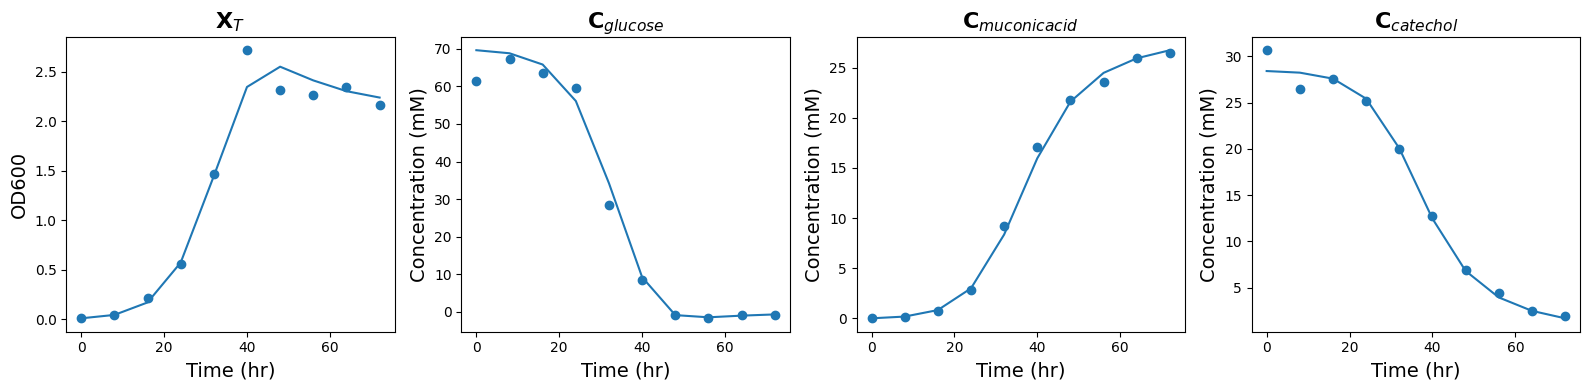

In [9]:
i = 0

fig, axs = plt.subplots(1,4,figsize = (16,4))
ax = axs.ravel()
Name = ["X$_T$", "C$_{glucose}$", "C$_{muconic acid}$", "C$_{catechol}$"]
ylabels = ["OD600", "Concentration (mM)", "Concentration (mM)", "Concentration (mM)"]

for j in range(4):
    ax[j].plot(time, s[i][j])
    ax[j].scatter(t, rc[i][j])
    ax[j].set_xlabel("Time (hr)", fontsize = 14)
    ax[j].set_ylabel(ylabels[j], fontsize = 14)
    ax[j].set_title(Name[j], fontweight = "bold", fontsize = 16)

plt.tight_layout()

# Integrated Model Construction

In [10]:
def ANN_int_mu_model(model,d,t):
    
    # This is the integrated ANN model
    # which will be embedded within the pyomo formulation
    
    Xt = model.conc_Xt[d,t]
    Cg = model.conc_Cg[d,t]
    Cm = model.conc_Cm[d,t]
    Cc = model.conc_Cc[d,t]
    
    h1_list = []
    
    # This calculates the first layer 
    for i in model.h1_num_nod:
        z1 = model.W1[0,i]*Xt + model.W1[1,i]*Cg + model.W1[2,i]*Cm + model.W1[3,i]*Cc + model.b1[i]
        h1 = (1/(1 + math.e**(-1*z1))) #(math.e**(2*z1) - 1)/(math.e**(2*z1) + 1)
        h1_list.append(h1)
    
    z2 = model.b2
    for i in model.h1_num_nod:
        z2 += model.W2[i]*h1_list[i]
    h3 = z2
    
    return h3

In [11]:
def dXtdt_int_con(model, d, t):
    # This captures the ODE dynamic equation for total biomass dynamics
    if t == 0:
        return Constraint.Skip
    mu = ANN_int_mu_model(model,d,t)
    return model.dXtdt[d,t] == mu*model.conc_Xt[d,t]

def dCgdt_int_con(model,d,t):
    # This captures the ODE dynamic equation for glucose concentration dynamics
    if t == 0:
        return Constraint.Skip
    mu = ANN_int_mu_model(model,d,t)
    return model.dCgdt[d,t] == -1*model.conc_Xt[d,t]*(mu*model.Ygx)*(model.max_vals[0]/model.max_vals[1])

def dCmdt_int_con(model,d,t):
    # This capture the ODE dynamic equations for muconic acid concentration dynamics
    if t == 0:
        return Constraint.Skip
    mu = ANN_int_mu_model(model,d,t)
    return model.dCmdt[d,t] == (model.Ymx*mu + model.beta)*model.conc_Xt[d,t]*(
        (model.conc_Cc[d,t])/(model.conc_Cc[d,t] + (model.kc/model.max_vals[3])))*(model.max_vals[0]/model.max_vals[2])

def dCcdt_int_con(model,d,t):
    # This captures the ODE dynamic equations for catechol concentration dynamics
    if t == 0:
        return Constraint.Skip
    return model.dCcdt[d,t] == -1*model.dCmdt[d,t]*(model.max_vals[2]/model.max_vals[3])

def objective_int_SSmse(model):
    # This is a state space objective function for the integrated model
    final = 0
    
    for i in model.d_idx:
        for j in model.t_meas:
            final += (model.conc_Xt_meas[i,j] - model.conc_Xt[i,j])**2
            final += (model.conc_Cg_meas[i,j] - model.conc_Cg[i,j])**2
            final += (model.conc_Cm_meas[i,j] - model.conc_Cm[i,j])**2
            final += (model.conc_Cc_meas[i,j] - model.conc_Cc[i,j])**2
    
    fin = final/(4*len(model.d_idx)*len(model.t_meas))
    
    return fin

In [12]:
def make_model_int_rs_fl(rs, fl):
    
    # This utilizes the above training data generating functions
    # to generate 10-points per initial condition at 10% gaussian noise
    # The initial condition file name and random seed is specified.
    
    num = 10
    err = 10
    rs = rs

    time, s = syn_data_generation(num, fl)
    t, rc = Error_addition(num, fl, err, rs)

    y_temp = []

    for i in range(3):
        y_temp.append(rc[i])

    no_touch_y = np.array(y_temp)
    no_touch_t = np.copy(t)

    n_d, n_s, n_t = np.shape(no_touch_y)

    t = no_touch_t
    y_temp = no_touch_y
    max_vals = np.max(np.max(no_touch_y, axis = 0), axis = 1)

    y_scaled = np.zeros(np.shape(y_temp))
    
    # The training data is converted from numpy files to dictionary
    # This is so that it can be utilized in pyomo formulation

    Xt_dict = {}
    Cg_dict = {}
    Cm_dict = {}
    Cc_dict = {}

    for j in range(n_d):
        for i in range(n_t):
            Xt_dict[(j,t[i])] = y_temp[j,0,i]/max_vals[0]
            y_scaled[j,0,i] = y_temp[j,0,i]/max_vals[0]

            Cg_dict[(j,t[i])] = y_temp[j,1,i]/max_vals[1]
            y_scaled[j,1,i] = y_temp[j,1,i]/max_vals[1]

            Cm_dict[(j,t[i])] = y_temp[j,2,i]/max_vals[2]
            y_scaled[j,2,i] = y_temp[j,2,i]/max_vals[2]

            Cc_dict[(j,t[i])] = y_temp[j,3,i]/max_vals[3]
            y_scaled[j,3,i] = y_temp[j,3,i]/max_vals[3]
            
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    # The number of nodes is setup and the following pyomo formulation was generated
    
    num_nodes = 1

    model = ConcreteModel()

    # Sets describing the raw dataset
    model.d_idx = Set(initialize = range(n_d))
    model.t_meas = Set(initialize = no_touch_t)

    # Sets and Param describing integrated ANN structure
    model.h1_num_nod = Set(initialize = range(num_nodes))
    model.num_inputs = Set(initialize = range(n_s))

    # Parameters - State Space data measurment
    model.max_vals = Param(range(4), initialize = max_vals)
    model.conc_Xt_meas = Param(model.d_idx, model.t_meas, initialize = Xt_dict)
    model.conc_Cg_meas = Param(model.d_idx, model.t_meas, initialize = Cg_dict)
    model.conc_Cm_meas = Param(model.d_idx, model.t_meas, initialize = Cm_dict)
    model.conc_Cc_meas = Param(model.d_idx, model.t_meas, initialize = Cc_dict)

    # Variables - Time invariant Parameters
    model.Ygx = Var(within = NonNegativeReals)
    model.Ymx = Var(within = NonNegativeReals)
    model.beta = Var(within = NonNegativeReals)
    model.kc = Var(within = NonNegativeReals)

    # Variables - Concentrations and derivatives
    model.time = ContinuousSet(initialize = model.t_meas, bounds = (0,72))

    model.conc_Xt = Var(model.d_idx, model.time, within = NonNegativeReals)
    model.conc_Cg = Var(model.d_idx, model.time, within = NonNegativeReals)
    model.conc_Cm = Var(model.d_idx, model.time, within = NonNegativeReals)
    model.conc_Cc = Var(model.d_idx, model.time, within = NonNegativeReals)

    model.dXtdt = DerivativeVar(model.conc_Xt, within = Reals)
    model.dCgdt = DerivativeVar(model.conc_Cg, within = Reals)
    model.dCmdt = DerivativeVar(model.conc_Cm, within = Reals)
    model.dCcdt = DerivativeVar(model.conc_Cc, within = Reals)

    # Variables - ANN weights and biases
    model.W1 = Var(model.num_inputs, model.h1_num_nod, bounds = (-1,1))
    model.b1 = Var(model.h1_num_nod, bounds = (-1,1))
    model.W2 = Var(model.h1_num_nod, bounds = (-1,1))
    model.b2 = Var(bounds = (-1,1))

    # Constraints - Hybrid ODEs
    model.deriv_Xt = Constraint(model.d_idx, model.time, rule = dXtdt_int_con)
    model.deriv_Cg = Constraint(model.d_idx, model.time, rule = dCgdt_int_con)
    model.deriv_Cm = Constraint(model.d_idx, model.time, rule = dCmdt_int_con)
    model.deriv_Cc = Constraint(model.d_idx, model.time, rule = dCcdt_int_con)

    # Objective - State space MSE
    model.obj = Objective(expr = objective_int_SSmse)

    # Descritizer for pyomo.dae
    discretizer = TransformationFactory('dae.collocation')

    discretizer.apply_to(model,nfe=n_t,
                         ncp=2,
                         scheme='LAGRANGE-RADAU')

    # Solver - multistart
    solver = SolverFactory("multistart")
    results = solver.solve(model,
                           suppress_unbounded_warning = True,
                           iterations = 50)

    print("Solver status:", results.solver.status)
    print("Termination Condition:", results.solver.termination_condition)
    print(value(model.obj))
    
    # This function returns the pyomo formulation model and the max values to perform
    # a max-scaling of the training data and other testing data
    return [max_vals, model]

In [13]:
def TIV_and_ANN_int_params(model):
    
    # This function takes in a integrated pyomo model
    # and it extracts the time invariant parameters and
    # the ANN weights and biases
    
    TIV_params = {}

    TIV_params["Ygx"] = value(model.Ygx)
    TIV_params["Ymx"] = value(model.Ymx)
    TIV_params["beta"] = value(model.beta)
    TIV_params["kc"] = value(model.kc)
    
    ANN_params = {}

    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    W1 = np.zeros((len(model.num_inputs), len(model.h1_num_nod)))
    b1 = np.zeros((len(model.h1_num_nod),1))
    W2 = np.zeros((len(model.h1_num_nod),1))

    for i in model.num_inputs:
        for j in model.h1_num_nod:
            W1[i,j] = value(model.W1[i,j])

    for i in model.h1_num_nod:
        b1[i] = value(model.b1[i])
        W2[i] = value(model.W2[i])

    ANN_params["W1"] = W1
    ANN_params["b1"] = b1
    ANN_params["W2"] = W2
    ANN_params["b2"] = value(model.b2)
    
    return [TIV_params, ANN_params]

## Integrated model assembly and testing

In [14]:
def ANN_int_growth_model(y, ANN_params):
    
    # This function takes in the Xt, Cg, Cm, Cc inputs
    # along with the weights and biases of the ANN to
    # calculate the total biomass growth rate
    
    Xt, Cg, Cm, Cc = y
    
    W1 = ANN_params["W1"]
    b1 = ANN_params["b1"]
    W2 = ANN_params["W2"]
    b2 = ANN_params["b2"]
    
    h1_list = []
    for i in range(np.shape(b1)[0]):
        z1 = W1[0,i]*Xt + W1[1,i]*Cg + W1[2,i]*Cm + W1[3,i]*Cc + b1[i,0]
        h1 = (1/(1 + math.e**(-1*z1))) #(math.e**(2*z1) - 1)/(math.e**(2*z1) + 1)
        h1_list.append(h1)
    
    z2 = b2
    for i in range(np.shape(W2)[0]):
        z2 += W2[i,0]*h1_list[i]
    h3 = z2
    
    return h3

In [15]:
def Int_HM_ODE(t,y, param_dict, ANN_params, max_vals):
    
    # This is the system of ODE which simulates
    # the hybrid model trained above and returns
    # the gradients of the changing species.
    
    Xt, Cg, Cm, Cc = y
    
    Ygx = param_dict["Ygx"]
    Ymx = param_dict["Ymx"]
    beta = param_dict["beta"]
    kc = param_dict["kc"]
    
    mu = ANN_int_growth_model(y, ANN_params)
    
    dXtdt = mu*Xt
    dCgdt = -1*Xt*(mu*Ygx)*(max_vals[0]/max_vals[1]) 
    dCmdt = (Ymx*mu + beta)*Xt*((Cc)/(Cc + (kc/max_vals[3])))*(max_vals[0]/max_vals[2])
    dCcdt = -1*dCmdt
    
    return [dXtdt, dCgdt, dCmdt, dCcdt]

In [16]:
def Int_HM_Org_model_comparison_time(y0, tdict, adict, max_vals): 
    
    # This function simulates the batch extrapolation scenario for a given
    # initial condtion for the integrated hybrid ODE model. The function returns
    # the R2 value between the integrated hybrid model and the ground truth model
    # for the same initial conditions. 
    
    y0 = y0
    y0_4 = np.delete(y0,1)
    tspan = (0, 200)


    sol_actual = solve_ivp(combined_ode_system, tspan, y0, args = tuple([y0[2]]), 
                           method = "Radau", t_eval = np.linspace(tspan[0],tspan[1],60))
    y_actual = sol_actual.y
    y_actual[0,:] = y_actual[0,:] + y_actual[1,:]
    y_actual = np.delete(y_actual, 1, axis = 0)

    y0_scaled = np.divide(y0_4, max_vals)
    sol_predict = solve_ivp(Int_HM_ODE, tspan, y0_scaled, args = tuple([tdict, adict, max_vals]),
                            method = "Radau", t_eval = np.linspace(tspan[0],tspan[1],60))
    y_predict = np.multiply(sol_predict.y, max_vals.reshape(-1,1))

    r2_list = [] #r2_score(y_actual, y_predict)#[]

    for j in range(4):
        r2_list.append(r2_score(y_actual[j,:], y_predict[j,:]))

    return np.mean(r2_list)

In [17]:
def Int_HM_Org_model_comparison_FB(y0, tdict, adict, max_vals): 
    
    # This function simulates the semi-batch extrapolation scenario for a given
    # initial condtion for the integrated hybrid ODE model. The semi-batch has
    # a spike input of glucose and catechol of 10 mM and 3 mM respectively every 25 hrs.
    # The function returns the R2 value between the integrated hybrid model and the ground truth model
    # for the same initial conditions. 
    
    y0 = y0
    y0_4 = np.delete(y0,1)
    tspan = (0, 200)

    sol_list = []
    t_init = 0
    t_fin = 25
    count = 0
    y0_org = y0[2]
    
    while t_fin <= tspan[-1]:
        sol_actual = solve_ivp(combined_ode_system, (t_init, t_fin), y0, args = tuple([y0_org + 10*count]), 
                           method = "Radau", t_eval = np.linspace(t_init,t_fin,10))

        sol_list.append(sol_actual)

        y0 = np.copy(sol_actual.y[:,-1])
        y0[2] += 10
        y0[-1] += 3

        t_init += 25
        t_fin += 25

    y = np.zeros((5,80))
    t = []
    for i in range(len(sol_list)):
        s = 10*i
        e = 10*(i+1)
        y[:,s:e] = sol_list[i].y
        t.append(sol_list[i].t)
    t_actual = np.array(t).reshape(-1,)

    y_actual = np.copy(y)
    y_actual[0,:] = y_actual[0,:] + y_actual[1,:]
    y_actual = np.delete(y_actual, 1, axis = 0)



    sol_list = []
    t_init = 0
    t_fin = 25

    y_predict = np.zeros((4,80))
    t = []
    c = 0

    while t_fin <= tspan[-1]:

        y0_scaled = np.divide(y0_4, max_vals)
        sol_predict = solve_ivp(Int_HM_ODE, (t_init, t_fin), y0_scaled, args = tuple([tdict, adict, max_vals]), 
                                method = "Radau", t_eval = np.linspace(t_init,t_fin,10))
        y_pr = np.multiply(sol_predict.y, max_vals.reshape(-1,1))

        y_predict[:,10*c:10*(c+1)] = np.copy(y_pr)
        t.append(np.copy(sol_predict.t))

        y0_4 = np.copy(y_pr[:,-1])
        y0_4[1] += 10
        y0_4[-1] += 3

        t_init += 25
        t_fin += 25
        c += 1

    t_predict = np.array(t).reshape(-1,1)
    
    r2_list = []

    for j in range(4):
        r2_list.append(r2_score(y_actual[j,:], y_predict[j,:]))

    return np.mean(r2_list)

In [18]:
# This generates a list of initial conditions to test the 
# the batch and semi-batch extrapolation of the integrated
# hybrid model. 

Cg_range = np.linspace(20, 100, 30)
Cc_range = np.linspace(5, 55, 30)

Xv_const = 0.01

rect1_cg_cc = []

for i in range(30):
    for j in range(30):
        rect1_cg_cc.append(np.array([Xv_const, 0, Cg_range[i], 0, Cc_range[j]]))

In [19]:
performance_dict = {}

In [20]:
# For different initial conditions and random seeds i.e traing data
# the batch and semi-batch extrapolation is tested and then stored 
# in dictionary

random_seed_list = [5, 10, 15, 20, 25]
file_list = ["Initial_conditions_3_1_PP.txt",
            "Initial_conditions_3_2_PP.txt",
            "Initial_conditions_3_3_PP.txt",
            "Initial_conditions_3_4_PP.txt",
            "Initial_conditions_3_5_PP.txt"]

for fl in range(len(file_list)):
    
    print(file_list[fl])
    perf_dict = {}
    
    for rs in range(len(random_seed_list)):
        
        try:
            max_vals, model_rs1 = make_model_int_rs_fl(random_seed_list[rs], file_list[fl])
        except ValueError:
            print("except")
            max_vals, model_rs1 = make_model_int_rs_fl(random_seed_list[rs]+1, file_list[fl])

        tdict, adict = TIV_and_ANN_int_params(model_rs1)

        rect_T_EX = []
        rect_FB_EX = []

        for i in range(900):
            rect_T_EX.append(Int_HM_Org_model_comparison_time(rect1_cg_cc[i], tdict, adict, max_vals))
            rect_FB_EX.append(Int_HM_Org_model_comparison_FB(rect1_cg_cc[i], tdict, adict, max_vals))

        perf_dict[random_seed_list[rs]] = [rect_T_EX, rect_FB_EX]
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    
    performance_dict[file_list[fl]] = perf_dict
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

Initial_conditions_3_1_PP.txt
Solver status: ok
Termination Condition: optimal
0.0028524966850536283
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.0018535310732182852
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.002901137128471369
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.0033487858808628327
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.0031477507471904614
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Initial_conditions_3_2_PP.txt
Solver status: ok
Termination Condition: optimal
0.002686188209158021
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.0022438523817927
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.003304187298016731
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.003

In [21]:
# This finds the average performance of the batch and
# semi-batch extrapolation for different initial conditions
# and random seed scenarios.

T_EX = []
FB_EX = []


for i in file_list:
    for j in random_seed_list:
        T_EX.append(performance_dict[i][j][0])
        FB_EX.append(performance_dict[i][j][1])

T_EX = np.array(T_EX)
FB_EX = np.array(FB_EX)

for i in range(np.shape(T_EX)[0]):
    for j in range(np.shape(T_EX)[1]):
        if T_EX[i,j] < 0:
            T_EX[i,j] = 0
        
        if FB_EX[i,j] < 0:
            FB_EX[i,j] = 0

T_EX = np.mean(np.array(T_EX), axis = 0)
FB_EX = np.mean(np.array(FB_EX), axis = 0)

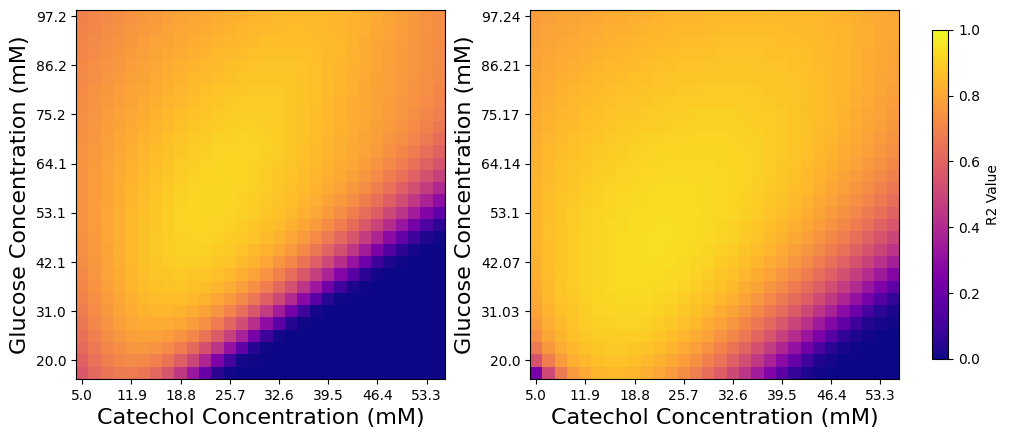

In [22]:
# The data made in the previous box
data1 = np.flipud(np.array(T_EX).reshape(30,30))
data2 = np.flipud(np.array(FB_EX).reshape(30,30))
cmap = "plasma"

# Create a figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

# Set a common color scale
vmin = 0
vmax = 1

# Create heatmaps
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
im1 = axes[0].imshow(data1, cmap= cmap, vmin=vmin, vmax=vmax)
x_label = []
for i in Cc_range[::4]:
    x_label.append(round(i,1))
y_label = []
for i in np.flipud(Cg_range[::4]):
    y_label.append(round(i,1))
axes[0].set_xticks(ticks = np.arange(30)[::4], labels = x_label)
axes[0].set_yticks(ticks = np.arange(30)[::4], labels = y_label)
axes[0].set_xlabel("Catechol Concentration (mM)", fontsize = 16)
axes[0].set_ylabel("Glucose Concentration (mM)", fontsize = 16)
#axes[0].set_title("Batch Extrapolation (200 hr)", fontsize = 16, fontweight = "bold")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
im2 = axes[1].imshow(data2, cmap= cmap, vmin=vmin, vmax=vmax)
x_label = []
for i in Cc_range[::4]:
    x_label.append(round(i,1))
y_label = []
for i in np.flipud(Cg_range[::4]):
    y_label.append(round(i,2))
axes[1].set_xticks(ticks = np.arange(30)[::4], labels = x_label)
axes[1].set_yticks(ticks = np.arange(30)[::4], labels = y_label)
axes[1].set_xlabel("Catechol Concentration (mM)", fontsize = 16)
axes[1].set_ylabel("Glucose Concentration (mM)", fontsize = 16)
#axes[1].set_title("Semi-Batch Extrapolation (200 hr)", fontsize = 16, fontweight = "bold")
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Add a common color bar
cbar = fig.colorbar(im1, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('R2 Value')

In [23]:
final_dict = {}
final_dict["HMI_Extrapolation"] = np.array([T_EX, FB_EX])

# Phenomenological model construction

In [24]:
def dXtdt_PM_con(model, d, t):
    # This captures the ODE dynamic equation for total biomass dynamics
    if t == 0:
        return Constraint.Skip
    mu_growth = (model.mu_g*model.conc_Cg[d,t])/(model.conc_Cg[d,t] + (model.kg/model.max_vals[1]))
    mu_death = (model.mu_c*model.conc_Cc[d,t])/(model.conc_Cc[d,t] + (model.kc/model.max_vals[3]))
    mu = mu_growth - mu_death
    return model.dXtdt[d,t] == mu*model.conc_Xt[d,t]

def dCgdt_PM_con(model,d,t):
    # This captures the ODE dynamic equation for glucose concentration dynamics
    if t == 0:
        return Constraint.Skip
    mu_growth = (model.mu_g*model.conc_Cg[d,t])/(model.conc_Cg[d,t] + (model.kg/model.max_vals[1]))
    mu_death = (model.mu_c*model.conc_Cc[d,t])/(model.conc_Cc[d,t] + (model.kc/model.max_vals[3]))
    mu = mu_growth - mu_death
    return model.dCgdt[d,t] == -1*model.conc_Xt[d,t]*(mu*model.Ygx)*(model.max_vals[0]/model.max_vals[1])

def dCmdt_PM_con(model,d,t):
    # This captures the ODE dynamic equation for muconic acid concentration dynamics
    if t == 0:
        return Constraint.Skip
    mu_growth = (model.mu_g*model.conc_Cg[d,t])/(model.conc_Cg[d,t] + (model.kg/model.max_vals[1]))
    mu_death = (model.mu_c*model.conc_Cc[d,t])/(model.conc_Cc[d,t] + (model.kc/model.max_vals[3]))
    mu = mu_growth - mu_death
    return model.dCmdt[d,t] == (model.Ymx*mu + model.beta)*model.conc_Xt[d,t]*(
        (model.conc_Cc[d,t])/(model.conc_Cc[d,t] + (model.kci/model.max_vals[3])))*(model.max_vals[0]/model.max_vals[2])

def dCcdt_PM_con(model,d,t):
    # This captures the ODE dynamic equation for catechol concentration dynamics
    if t == 0:
        return Constraint.Skip
    return model.dCcdt[d,t] == -1*model.dCmdt[d,t]*(model.max_vals[2]/model.max_vals[3])

def objective_PM_SSmse(model):
    # This is a state space objective function for the phenomenological model
    final = 0
    
    for i in model.d_idx:
        for j in model.t_meas:
            final += (model.conc_Xt_meas[i,j] - model.conc_Xt[i,j])**2
            final += (model.conc_Cg_meas[i,j] - model.conc_Cg[i,j])**2
            final += (model.conc_Cm_meas[i,j] - model.conc_Cm[i,j])**2
            final += (model.conc_Cc_meas[i,j] - model.conc_Cc[i,j])**2
    
    fin = final/(4*len(model.d_idx)*len(model.t_meas))
    
    return fin

In [25]:
def make_model_PM_rs_fl(rs1, fl):
    
    # This utilizes the above training data generating functions
    # to generate 10-points per initial condition at 10% gaussian noise
    # The initial condition file name and random seed is specified.
    
    num = 10
    err = 10
    rs = rs1

    time, s = syn_data_generation(num, fl)
    t, rc = Error_addition(num, fl, err, rs)

    y_temp = []

    for i in range(3):
        y_temp.append(rc[i])

    no_touch_y = np.array(y_temp)
    no_touch_t = np.copy(t)

    n_d, n_s, n_t = np.shape(no_touch_y)

    t = no_touch_t
    y_temp = no_touch_y
    max_vals = np.max(np.max(no_touch_y, axis = 0), axis = 1)

    y_scaled = np.zeros(np.shape(y_temp))

    # The training data is converted from numpy files to dictionary
    # This is so that it can be utilized in pyomo formulation
    
    Xt_dict = {}
    Cg_dict = {}
    Cm_dict = {}
    Cc_dict = {}

    for j in range(n_d):
        for i in range(n_t):
            Xt_dict[(j,t[i])] = y_temp[j,0,i]/max_vals[0]
            y_scaled[j,0,i] = y_temp[j,0,i]/max_vals[0]

            Cg_dict[(j,t[i])] = y_temp[j,1,i]/max_vals[1]
            y_scaled[j,1,i] = y_temp[j,1,i]/max_vals[1]

            Cm_dict[(j,t[i])] = y_temp[j,2,i]/max_vals[2]
            y_scaled[j,2,i] = y_temp[j,2,i]/max_vals[2]

            Cc_dict[(j,t[i])] = y_temp[j,3,i]/max_vals[3]
            y_scaled[j,3,i] = y_temp[j,3,i]/max_vals[3]

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    model = ConcreteModel()

    # Sets describing the raw dataset
    model.d_idx = Set(initialize = range(n_d))
    model.t_meas = Set(initialize = no_touch_t)

    # Parameters - State Space data measurment
    model.max_vals = Param(range(4), initialize = max_vals)
    model.conc_Xt_meas = Param(model.d_idx, model.t_meas, initialize = Xt_dict)
    model.conc_Cg_meas = Param(model.d_idx, model.t_meas, initialize = Cg_dict)
    model.conc_Cm_meas = Param(model.d_idx, model.t_meas, initialize = Cm_dict)
    model.conc_Cc_meas = Param(model.d_idx, model.t_meas, initialize = Cc_dict)

    # Variables - Time invariant Parameters
    model.mu_g = Var(within = NonNegativeReals)
    model.kg = Var(within = NonNegativeReals)
    model.mu_c = Var(within = NonNegativeReals)
    model.kc = Var(within = NonNegativeReals)
    model.Ygx = Var(within = NonNegativeReals)
    model.Ymx = Var(within = NonNegativeReals)
    model.beta = Var(within = NonNegativeReals)
    model.kci = Var(within = NonNegativeReals)

    # Variables - Concentrations and derivatives
    model.time = ContinuousSet(initialize = model.t_meas, bounds = (0,72))

    model.conc_Xt = Var(model.d_idx, model.time, within = NonNegativeReals)
    model.conc_Cg = Var(model.d_idx, model.time, within = NonNegativeReals)
    model.conc_Cm = Var(model.d_idx, model.time, within = NonNegativeReals)
    model.conc_Cc = Var(model.d_idx, model.time, within = NonNegativeReals)

    model.dXtdt = DerivativeVar(model.conc_Xt, within = Reals)
    model.dCgdt = DerivativeVar(model.conc_Cg, within = Reals)
    model.dCmdt = DerivativeVar(model.conc_Cm, within = Reals)
    model.dCcdt = DerivativeVar(model.conc_Cc, within = Reals)

    # Constraints - Hybrid ODEs
    model.deriv_Xt = Constraint(model.d_idx, model.time, rule = dXtdt_PM_con)
    model.deriv_Cg = Constraint(model.d_idx, model.time, rule = dCgdt_PM_con)
    model.deriv_Cm = Constraint(model.d_idx, model.time, rule = dCmdt_PM_con)
    model.deriv_Cc = Constraint(model.d_idx, model.time, rule = dCcdt_PM_con)

    # Objective - State space MSE
    model.obj = Objective(expr = objective_PM_SSmse)

    # Descritizer for pyomo.dae
    discretizer = TransformationFactory('dae.collocation')

    discretizer.apply_to(model,nfe=n_t,
                         ncp=2,
                         scheme='LAGRANGE-RADAU')

    # Solver - multistart
    #try :
    solver = SolverFactory("multistart")
    results = solver.solve(model,
                           suppress_unbounded_warning = True,
                           iterations = 50)#, 
    #                       tee = True)

    print("Solver status:", results.solver.status)
    print("Termination Condition:", results.solver.termination_condition)
    print(value(model.obj))
    
    return [max_vals, model]

In [26]:
def TIV_PM_params(model):
    
    # This function takes in a phenomenological pyomo model
    # and it extracts the time invariant parameters
    
    TIV_params = {}

    TIV_params["mu_g"] = value(model.mu_g)
    TIV_params["kg"] = value(model.kg)
    TIV_params["mu_c"] = value(model.mu_c)
    TIV_params["kc"] = value(model.kc)
    TIV_params["Ygx"] = value(model.Ygx)
    TIV_params["Ymx"] = value(model.Ymx)
    TIV_params["beta"] = value(model.beta)
    TIV_params["kci"] = value(model.kci)
    
    return TIV_params

## Phenomenological model assembly and testing

In [27]:
def Phenom_ODE(t,y, param_dict, max_vals):
    
    # This is the system of ODE which simulates
    # the phnomenological model trained above and returns
    # the gradients of the changing species.
    
    Xt, Cg, Cm, Cc = y
    
    mu_g = param_dict["mu_g"]
    kg = param_dict["kg"]
    mu_c = param_dict["mu_c"]
    kc = param_dict["kc"]
    Ygx = param_dict["Ygx"]
    Ymx = param_dict["Ymx"]
    beta = param_dict["beta"]
    kci = param_dict["kci"]
    
    mu_growth = (mu_g*Cg)/(Cg + (kg/max_vals[1]))
    mu_death = (mu_c*Cc)/(Cc + (kc/max_vals[3]))
    mu = mu_growth - mu_death
    
    dXtdt = mu*Xt
    dCgdt = -1*Xt*(mu*Ygx)*(max_vals[0]/max_vals[1])
    dCmdt = (Ymx*mu + beta)*Xt*((Cc)/(Cc + (kci/max_vals[3])))*(max_vals[0]/max_vals[2])
    dCcdt = -1*dCmdt*(max_vals[3]/max_vals[2])
    
    return [dXtdt, dCgdt, dCmdt, dCcdt]

In [28]:
def Phenom_Org_model_comparison_time(y0, tdict, max_vals): 
    
    # This function simulates the batch extrapolation scenario for a given
    # initial condtion for the phenomenological ODE model. The function returns
    # the R2 value between the phenomenological model and the ground truth model
    # for the same initial conditions. 
    
    y0 = y0
    y0_4 = np.delete(y0,1)
    tspan = (0, 200)


    sol_actual = solve_ivp(combined_ode_system, tspan, y0, args = tuple([y0[2]]), 
                           method = "Radau", t_eval = np.linspace(tspan[0],tspan[1],60))
    y_actual = sol_actual.y
    y_actual[0,:] = y_actual[0,:] + y_actual[1,:]
    y_actual = np.delete(y_actual, 1, axis = 0)

    y0_scaled = np.divide(y0_4, max_vals)
    sol_predict = solve_ivp(Phenom_ODE, tspan, y0_scaled, args = tuple([tdict, max_vals]),
                            method = "Radau", t_eval = np.linspace(tspan[0],tspan[1],60))
    y_predict = np.multiply(sol_predict.y, max_vals.reshape(-1,1))

    r2_list = [] #r2_score(y_actual, y_predict)#[]

    for j in range(4):
        r2_list.append(r2_score(y_actual[j,:], y_predict[j,:]))

    return np.mean(r2_list)

In [29]:
def Phenom_Org_model_comparison_FB(y0, tdict, max_vals):

    # This function simulates the semi-batch extrapolation scenario for a given
    # initial condtion for the phenomenological ODE model. The semi-batch has
    # a spike input of glucose and catechol of 10 mM and 3 mM respectively every 25 hrs.
    # The function returns the R2 value between the integrated hybrid model and the ground truth model
    # for the same initial conditions.     
    
    y0 = y0
    y0_4 = np.delete(y0,1)
    tspan = (0, 200)

    sol_list = []
    t_init = 0
    t_fin = 25
    count = 0
    y0_org = y0[2]

    while t_fin <= tspan[-1]:
        sol_actual = solve_ivp(combined_ode_system, (t_init, t_fin), y0, args = tuple([y0_org+10*count]), 
                           method = "Radau", t_eval = np.linspace(t_init,t_fin,10))

        sol_list.append(sol_actual)

        y0 = np.copy(sol_actual.y[:,-1])
        y0[2] += 10
        y0[-1] += 3

        t_init += 25
        t_fin += 25

    y = np.zeros((5,80))
    t = []
    for i in range(len(sol_list)):
        s = 10*i
        e = 10*(i+1)
        y[:,s:e] = sol_list[i].y
        t.append(sol_list[i].t)
    t_actual = np.array(t).reshape(-1,)

    y_actual = np.copy(y)
    y_actual[0,:] = y_actual[0,:] + y_actual[1,:]
    y_actual = np.delete(y_actual, 1, axis = 0)



    sol_list = []
    t_init = 0
    t_fin = 25

    y_predict = np.zeros((4,80))
    t = []
    c = 0

    while t_fin <= tspan[-1]:

        y0_scaled = np.divide(y0_4, max_vals)
        sol_predict = solve_ivp(Phenom_ODE, (t_init, t_fin), y0_scaled, args = tuple([tdict, max_vals]),
                                method = "Radau", t_eval = np.linspace(t_init,t_fin,10))
        y_pr = np.multiply(sol_predict.y, max_vals.reshape(-1,1))

        y_predict[:,10*c:10*(c+1)] = np.copy(y_pr)
        t.append(np.copy(sol_predict.t))

        y0_4 = np.copy(y_pr[:,-1])
        y0_4[1] += 10
        y0_4[-1] += 3

        t_init += 25
        t_fin += 25
        c += 1

    t_predict = np.array(t).reshape(-1,1)
    
    r2_list = []

    for j in range(4):
        r2_list.append(r2_score(y_actual[j,:], y_predict[j,:]))

    return np.mean(r2_list)

In [30]:
# For different initial conditions and random seeds i.e traing data
# the batch and semi-batch extrapolation is tested and then stored 
# in dictionary

random_seed_list = [5, 10, 15, 20, 25]
file_list = ["Initial_conditions_3_1_PP.txt",
            "Initial_conditions_3_2_PP.txt",
            "Initial_conditions_3_3_PP.txt",
            "Initial_conditions_3_4_PP.txt",
            "Initial_conditions_3_5_PP.txt"]
performance_dict = {}


for fl in range(len(file_list)):
    
    print(file_list[fl])
    perf_dict = {}
    
    for rs in range(len(random_seed_list)):
        
        try:
            max_vals, model_rs1 = make_model_PM_rs_fl(random_seed_list[rs], file_list[fl])
        except ValueError:
            print("except")
            max_vals, model_rs1 = make_model_PM_rs_fl(random_seed_list[rs]+1, file_list[fl])

        tdict = TIV_PM_params(model_rs1)

        rect_T_EX = []
        rect_FB_EX = []

        for i in range(900):
            rect_T_EX.append(Phenom_Org_model_comparison_time(rect1_cg_cc[i], tdict, max_vals))
            rect_FB_EX.append(Phenom_Org_model_comparison_FB(rect1_cg_cc[i], tdict, max_vals))

        perf_dict[random_seed_list[rs]] = [rect_T_EX, rect_FB_EX]
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    
    performance_dict[file_list[fl]] = perf_dict
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

Initial_conditions_3_1_PP.txt
Solver status: ok
Termination Condition: optimal
0.0027735324234383894
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.0018681906273846458
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.0033759196804457503
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.0033957444591324244
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.003149056051207011
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Initial_conditions_3_2_PP.txt
Solver status: ok
Termination Condition: optimal
0.0026092079191287186
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.0023208510012858227
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.0032930328426873023
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal


In [31]:
# This finds the average performance of the batch and
# semi-batch extrapolation for different initial conditions
# and random seed scenarios.

T_EX = []
FB_EX = []


for i in file_list:
    for j in random_seed_list:
        T_EX.append(performance_dict[i][j][0])
        FB_EX.append(performance_dict[i][j][1])

T_EX = np.array(T_EX)
FB_EX = np.array(FB_EX)

for i in range(np.shape(T_EX)[0]):
    for j in range(np.shape(T_EX)[1]):
        if T_EX[i,j] < 0:
            T_EX[i,j] = 0
        
        if FB_EX[i,j] < 0:
            FB_EX[i,j] = 0

T_EX = np.mean(np.array(T_EX), axis = 0)
FB_EX = np.mean(np.array(FB_EX), axis = 0)

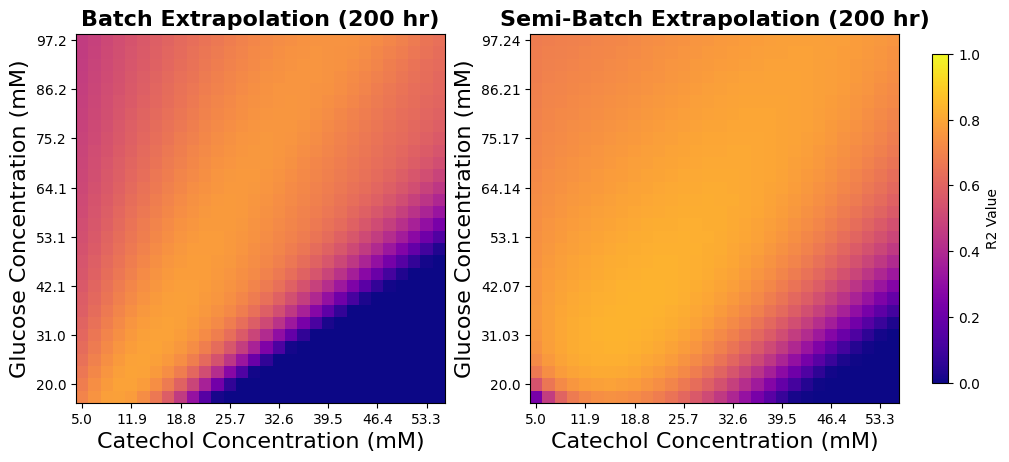

In [32]:
# Generate some example data for the heatmaps
data1 = np.flipud(np.array(T_EX).reshape(30,30))
data2 = np.flipud(np.array(FB_EX).reshape(30,30))
cmap = "plasma"

# Create a figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

# Set a common color scale
vmin = 0
vmax = 1

# Create heatmaps
im1 = axes[0].imshow(data1, cmap= cmap, vmin=vmin, vmax=vmax)
x_label = []
for i in Cc_range[::4]:
    x_label.append(round(i,1))
y_label = []
for i in np.flipud(Cg_range[::4]):
    y_label.append(round(i,1))
axes[0].set_xticks(ticks = np.arange(30)[::4], labels = x_label)
axes[0].set_yticks(ticks = np.arange(30)[::4], labels = y_label)
axes[0].set_xlabel("Catechol Concentration (mM)", fontsize = 16)
axes[0].set_ylabel("Glucose Concentration (mM)", fontsize = 16)
axes[0].set_title("Batch Extrapolation (200 hr)", fontsize = 16, fontweight = "bold")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

im2 = axes[1].imshow(data2, cmap= cmap, vmin=vmin, vmax=vmax)
x_label = []
for i in Cc_range[::4]:
    x_label.append(round(i,1))
y_label = []
for i in np.flipud(Cg_range[::4]):
    y_label.append(round(i,2))
axes[1].set_xticks(ticks = np.arange(30)[::4], labels = x_label)
axes[1].set_yticks(ticks = np.arange(30)[::4], labels = y_label)
axes[1].set_xlabel("Catechol Concentration (mM)", fontsize = 16)
axes[1].set_ylabel("Glucose Concentration (mM)", fontsize = 16)
axes[1].set_title("Semi-Batch Extrapolation (200 hr)", fontsize = 16, fontweight = "bold")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Add a common color bar
cbar = fig.colorbar(im1, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('R2 Value')

In [33]:
final_dict["PM_Extrapolation"] = np.array([T_EX, FB_EX])

# Machine Learning Model construction

In [34]:
def make_model_ML_rs_fl(rs1, fl):
    
    # This utilizes the above training data generating functions
    # to generate 10-points per initial condition at 10% gaussian noise
    # The initial condition file name and random seed is specified.
    
    num = 10
    err = 10
    rs = rs1

    time, s = syn_data_generation(num, fl)
    t, rc = Error_addition(num, fl, err, rs)

    y_temp = []

    for i in range(len(s)):
        y_temp.append(rc[i])

    y_temp = np.array(y_temp)
    no_touch_t = np.copy(t)

    n_d, n_s, n_t = np.shape(y_temp)

    t = no_touch_t

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    # The training and testing data are put into approporiate
    # X (inputs) and y (outputs) lists to perform downstream ML regression 
    
    X = []
    y = []

    for i in range(n_d):
        for j in range(n_t):
            tempX = np.append(y_temp[i,:,0], t[j])
            tempy = y_temp[i,:,j]

            X.append(tempX)
            y.append(tempy)

    X = np.array(X)
    y = np.array(y)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    # A test-train split of 20% is done and a standard scaling
    # is performed to scale both the inputs and outputs
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

    SS_x = StandardScaler()
    SS_y = StandardScaler()

    X_train_scaled = SS_x.fit_transform(X_train)
    X_test_scaled = SS_x.transform(X_test)

    y_train_scaled = SS_y.fit_transform(y_train)
    y_test_scaled = SS_y.transform(y_test)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    # A hyperpramater grid search is performed which to determine
    # the best regressive model which was able to predict the output
    # to the input. 
    
    mlp = MLPRegressor(early_stopping = True,
                              max_iter = 10000,
                              random_state = 42, 
                              shuffle = True,
                              validation_fraction = 0.2)
    hls = []
    numnodes = [5, 10, 15, 20, 30, 35, 40]

    for i in numnodes:
        hls.append(tuple([i]))
        for j in numnodes:
            hls.append(tuple([i,j]))
#             for k in numnodes:
#                 hls.append(tuple([i,j,k]))


    param_grid = {
        "hidden_layer_sizes" : hls,
        "activation" : ["tanh", "logistic"],
        "alpha" : np.logspace(-5, -2, 5)
    }
    
    grid_search = GridSearchCV(mlp, 
                           param_grid,
                           n_jobs = -1,
                           verbose = 3,
                           return_train_score = True
                          )
    grid_search.fit(X_train_scaled, y_train_scaled)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    # The function outputs the trained ML regressor, and standard
    # scaling models which can be used for downstream extrapolation
    
    best_estimator = grid_search.best_estimator_
    
    SS_x = StandardScaler()
    SS_y = StandardScaler()

    X_scaled = SS_x.fit_transform(X)

    y_scaled = SS_y.fit_transform(y)

    best_estimator.fit(X_scaled, y_scaled)
    
    return [SS_x, SS_y, best_estimator]

## ML model assembly and testing

In [35]:
def BB_ODE(x, SS_x, SS_y, ANN):
    
    # This function takes in a ML regessor, and standard
    # scalers along with an input which consists of the initial
    # condition and a time point t. The function returns the predicted
    # results for the given input
    
    tempx_scaled = SS_x.transform(x.reshape(1,-1))
    
    y_predict_scaled = ANN.predict(tempx_scaled)
    
    y_predict = SS_y.inverse_transform(y_predict_scaled)
    
    return y_predict

In [36]:
def BB_Org_model_comparison_time(y0, SS_x, SS_y, ANN):
    
    # This function simulates the batch extrapolation scenario for a given
    # initial condtion for the ML ODE model. The function returns
    # the R2 value between the ML model and the ground truth model
    # for the same initial conditions. 
    
    y0 = y0
    y0_4 = np.delete(y0,1)
    tspan = (0, 200)


    sol_actual = solve_ivp(combined_ode_system, tspan, y0, args = tuple([y0[2]]), 
                           method = "Radau", t_eval = np.linspace(tspan[0],tspan[1],60))
    y_actual = sol_actual.y
    y_actual[0,:] = y_actual[0,:] + y_actual[1,:]
    y_actual = np.delete(y_actual, 1, axis = 0)

    y_predict = []
    for i in sol_actual.t:
        X = np.append(y0_4, i)
        y_predict.append(BB_ODE(X, SS_x, SS_y, ANN))
    y_predict = np.array(y_predict).T.reshape(4,len(sol_actual.t))

    r2_list = [] #r2_score(y_actual, y_predict)#[]

    for j in range(4):
        r2_list.append(r2_score(y_actual[j,:], y_predict[j,:]))

    return np.mean(r2_list)

In [37]:
def BB_Org_model_comparison_FB(y0, SS_x, SS_y, ANN):
    
    # This function simulates the semi-batch extrapolation scenario for a given
    # initial condtion for the ML ODE model. The semi-batch has
    # a spike input of glucose and catechol of 10 mM and 3 mM respectively every 25 hrs.
    # The function returns the R2 value between the integrated hybrid model and the ground truth model
    # for the same initial conditions.    
    
    y0 = y0
    y0_4 = np.delete(y0,1)
    tspan = (0, 200)

    sol_list = []
    t_init = 0
    t_fin = 25
    count = 0

    while t_fin <= tspan[-1]:
        sol_actual = solve_ivp(combined_ode_system, (t_init, t_fin), y0, args = tuple([82+10*count]), 
                           method = "Radau", t_eval = np.linspace(t_init,t_fin,10))

        sol_list.append(sol_actual)

        y0 = np.copy(sol_actual.y[:,-1])
        y0[2] += 10
        y0[-1] += 3

        t_init += 25
        t_fin += 25

    y = np.zeros((5,80))
    t = []
    for i in range(len(sol_list)):
        s = 10*i
        e = 10*(i+1)
        y[:,s:e] = sol_list[i].y
        t.append(sol_list[i].t)
    t_actual = np.array(t).reshape(-1,)

    y_actual = np.copy(y)
    y_actual[0,:] = y_actual[0,:] + y_actual[1,:]
    y_actual = np.delete(y_actual, 1, axis = 0)

    y_predict = np.zeros((4,80))
    
    for i in range(len(sol_list)):
        y_pr = []
        for j in sol_list[0].t:
            X = np.append(y0_4, j)
            y_pr.append(BB_ODE(X, SS_x, SS_y, ANN))
        y_pr = np.array(y_pr).T.reshape(4, len(sol_list[0].t))
        
        y_predict[:, 10*i:10*(i+1)] = np.copy(y_pr)
        
        y0_4 = np.copy(y_pr[:,-1])
        y0_4[1] += 10
        y0_4[-1] += 3
        

    r2_list = []

    for j in range(4):
        r2_list.append(r2_score(y_actual[j,:], y_predict[j,:]))

    return np.mean(r2_list)

In [38]:
# For different initial conditions and random seeds i.e traing data
# the batch and semi-batch extrapolation is tested and then stored 
# in dictionary

random_seed_list = [5, 10, 15, 20, 25]
file_list = ["Initial_conditions_3_1_PP.txt",
            "Initial_conditions_3_2_PP.txt",
            "Initial_conditions_3_3_PP.txt",
            "Initial_conditions_3_4_PP.txt",
            "Initial_conditions_3_5_PP.txt"]
performance_dict = {}


for fl in range(len(file_list)):
    
    print(file_list[fl])
    perf_dict = {}
    
    for rs in range(len(random_seed_list)):
        
        try:
            SS_x, SS_y, ANN = make_model_ML_rs_fl(random_seed_list[rs], file_list[fl])
        except ValueError:
            print("except")
            SS_x, SS_y, ANN = make_model_ML_rs_fl(random_seed_list[rs]+1, file_list[fl])

        rect_T_EX = []
        rect_FB_EX = []

        for i in range(900):
            rect_T_EX.append(BB_Org_model_comparison_time(rect1_cg_cc[i], SS_x, SS_y, ANN))
            rect_FB_EX.append(BB_Org_model_comparison_FB(rect1_cg_cc[i], SS_x, SS_y, ANN))

        perf_dict[random_seed_list[rs]] = [rect_T_EX, rect_FB_EX]
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    
    performance_dict[file_list[fl]] = perf_dict
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

Initial_conditions_3_1_PP.txt
Fitting 5 folds for each of 560 candidates, totalling 2800 fits
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Fitting 5 folds for each of 560 candidates, totalling 2800 fits
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Fitting 5 folds for each of 560 candidates, totalling 2800 fits
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Fitting 5 folds for each of 560 candidates, totalling 2800 fits
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Fitting 5 folds for each of 560 candidates, totalling 2800 fits
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Initial_conditions_3_2_PP.txt
Fitting 5 folds for each of 560 candidates, totalling 2800 fits
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Fitting 5 folds for each of 560 candidates, totalling 2800 fits
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Fitting 5 folds for each of 560 candidates, totalling 2800 fits
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Fitting 5 folds for each of 560 candidates, totalling 2800 fits
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Fitt

In [39]:
# This finds the average performance of the batch and
# semi-batch extrapolation for different initial conditions
# and random seed scenarios.

T_EX = []
FB_EX = []


for i in file_list:
    for j in random_seed_list:
        T_EX.append(performance_dict[i][j][0])
        FB_EX.append(performance_dict[i][j][1])

T_EX = np.array(T_EX)
FB_EX = np.array(FB_EX)

for i in range(np.shape(T_EX)[0]):
    for j in range(np.shape(T_EX)[1]):
        if T_EX[i,j] < 0:
            T_EX[i,j] = 0
        
        if FB_EX[i,j] < 0:
            FB_EX[i,j] = 0

T_EX = np.mean(np.array(T_EX), axis = 0)
FB_EX = np.mean(np.array(FB_EX), axis = 0)

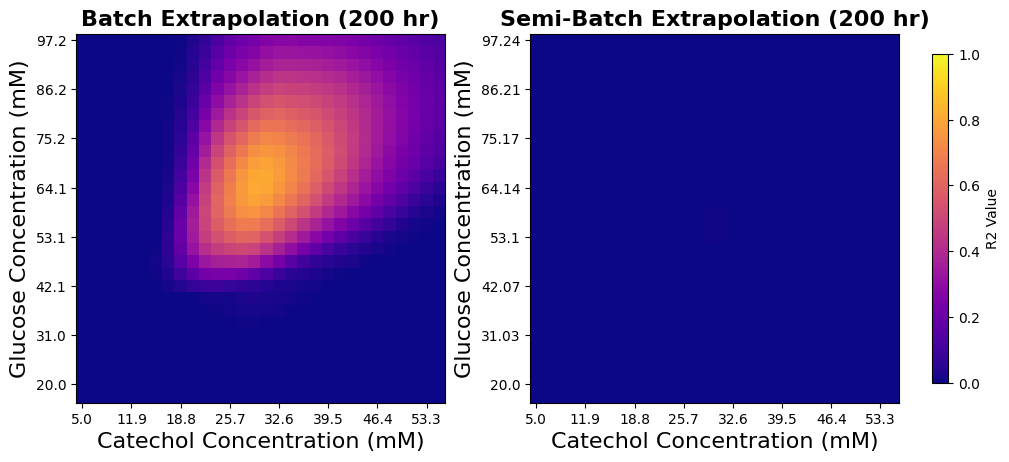

In [40]:
# Generate some example data for the heatmaps
data1 = np.flipud(np.array(T_EX).reshape(30,30))
data2 = np.flipud(np.array(FB_EX).reshape(30,30))
cmap = "plasma"

# Create a figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

# Set a common color scale
vmin = 0
vmax = 1

# Create heatmaps
im1 = axes[0].imshow(data1, cmap= cmap, vmin=vmin, vmax=vmax)
x_label = []
for i in Cc_range[::4]:
    x_label.append(round(i,1))
y_label = []
for i in np.flipud(Cg_range[::4]):
    y_label.append(round(i,1))
axes[0].set_xticks(ticks = np.arange(30)[::4], labels = x_label)
axes[0].set_yticks(ticks = np.arange(30)[::4], labels = y_label)
axes[0].set_xlabel("Catechol Concentration (mM)", fontsize = 16)
axes[0].set_ylabel("Glucose Concentration (mM)", fontsize = 16)
axes[0].set_title("Batch Extrapolation (200 hr)", fontsize = 16, fontweight = "bold")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

im2 = axes[1].imshow(data2, cmap= cmap, vmin=vmin, vmax=vmax)
x_label = []
for i in Cc_range[::4]:
    x_label.append(round(i,1))
y_label = []
for i in np.flipud(Cg_range[::4]):
    y_label.append(round(i,2))
axes[1].set_xticks(ticks = np.arange(30)[::4], labels = x_label)
axes[1].set_yticks(ticks = np.arange(30)[::4], labels = y_label)
axes[1].set_xlabel("Catechol Concentration (mM)", fontsize = 16)
axes[1].set_ylabel("Glucose Concentration (mM)", fontsize = 16)
axes[1].set_title("Semi-Batch Extrapolation (200 hr)", fontsize = 16, fontweight = "bold")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Add a common color bar
cbar = fig.colorbar(im1, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('R2 Value')

In [41]:
final_dict["ML_Extrapolation"] = np.array([T_EX, FB_EX])

# Final Performance Evaluation

In [42]:
int_list = []
file_list = ["Initial_conditions_3_1_PP.txt",
            "Initial_conditions_3_2_PP.txt",
            "Initial_conditions_3_3_PP.txt",
            "Initial_conditions_3_4_PP.txt",
            "Initial_conditions_3_5_PP.txt"]

for i in file_list:
    fl = "Initial_conditions\\" + i
    int_list.append(np.loadtxt(fl))

In [43]:
# Finds the coordinate for the sampling space on the heatmap

a = np.array(int_list)

Cg_min = np.min(a[:,:,2])
Cc_min = np.min(a[:,:,-1])

Cg_max = np.max(a[:,:,2])
Cc_max = np.max(a[:,:,-1])

x_min = (30/50)*(Cc_min - 5)
x_max = (30/50)*(Cc_max - 5)

y_min = (30/80)*(Cg_min - 20)
y_max = (30/80)*(Cg_max - 20)

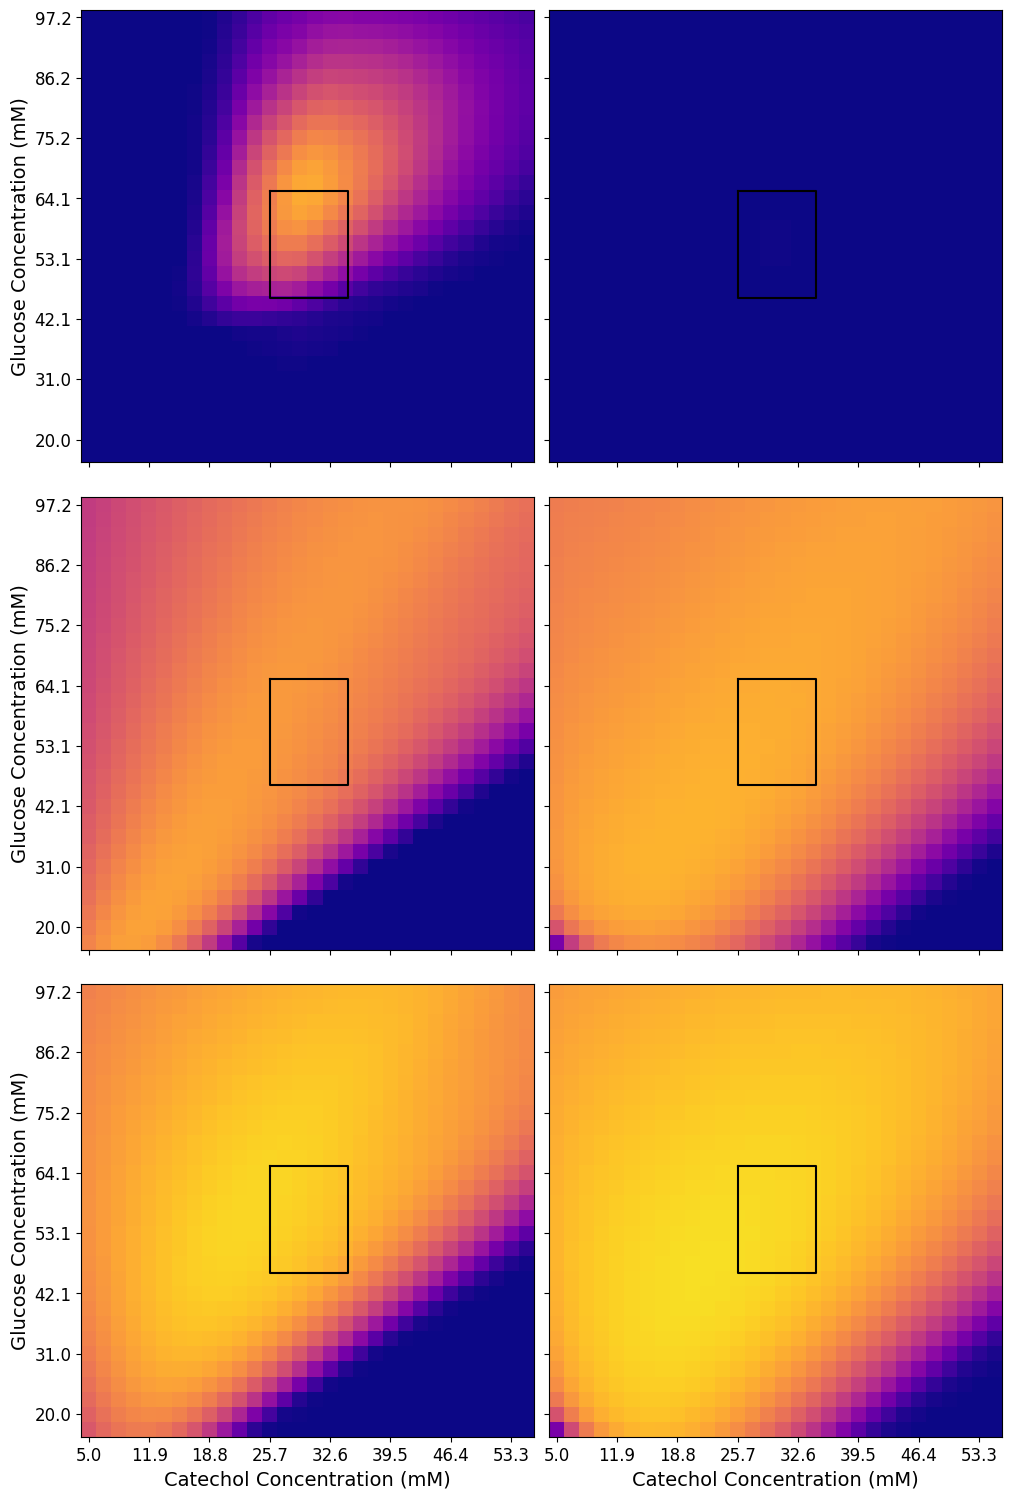

In [45]:
cmap = "plasma"
vmin = 0
vmax = 1
titles = {"ML_Extrapolation" : "Black Box Model", "PM_Extrapolation": "Phenom Model", "HMI_Extrapolation" : "Hybrid Model"}
keys = list(titles.keys())

Cg_range = np.linspace(20, 100, 30)
Cc_range = np.linspace(5, 55, 30)

Xv_const = 0.01


# Create a figure and subplots
fig, axes = plt.subplots(3, 2, figsize=(10,15), constrained_layout=True, sharex = True, sharey = True)

for z in range(len(keys)):
    data1 =  np.flipud(final_dict[keys[z]][0].reshape(30,30))
    data2 =  np.flipud(final_dict[keys[z]][1].reshape(30,30))

    # Create heatmaps
    im1 = axes[z,0].imshow(data1, cmap= cmap, vmin=vmin, vmax=vmax)
    x_label = []
    for i in Cc_range[::4]:
        x_label.append(round(i,1))
    y_label = []
    for i in np.flipud(Cg_range[::4]):
        y_label.append(round(i,1))
    axes[z,0].set_xticks(ticks = np.arange(30)[::4], labels = x_label, fontsize = 12)
    axes[z,0].set_yticks(ticks = np.arange(30)[::4], labels = y_label, fontsize = 12)
    if z == 2: 
        axes[z,0].set_xlabel("Catechol Concentration (mM)", fontsize = 14)
    axes[z,0].set_ylabel("Glucose Concentration (mM)", fontsize = 14)
    axes[z,0].plot([x_min, x_max, x_max, x_min, x_min],[y_min, y_min, y_max, y_max, y_min ],"k")
    #axes[z,0].set_ylabel(titles[keys[z]], fontsize = 16, fontweight = "bold")

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    im2 = axes[z,1].imshow(data2, cmap= cmap, vmin=vmin, vmax=vmax)
    x_label = []
    for i in Cc_range[::4]:
        x_label.append(round(i,1))
    y_label = []
    for i in np.flipud(Cg_range[::4]):
        y_label.append(round(i,1))
    axes[z,1].set_xticks(ticks = np.arange(30)[::4], labels = x_label, fontsize = 12)
    axes[z,1].set_yticks(ticks = np.arange(30)[::4], labels = y_label, fontsize = 12)
    if z == 2:
        axes[z,1].set_xlabel("Catechol Concentration (mM)", fontsize = 14)
    axes[z,1].plot([x_min, x_max, x_max, x_min, x_min],[y_min, y_min, y_max, y_max, y_min ],"k")

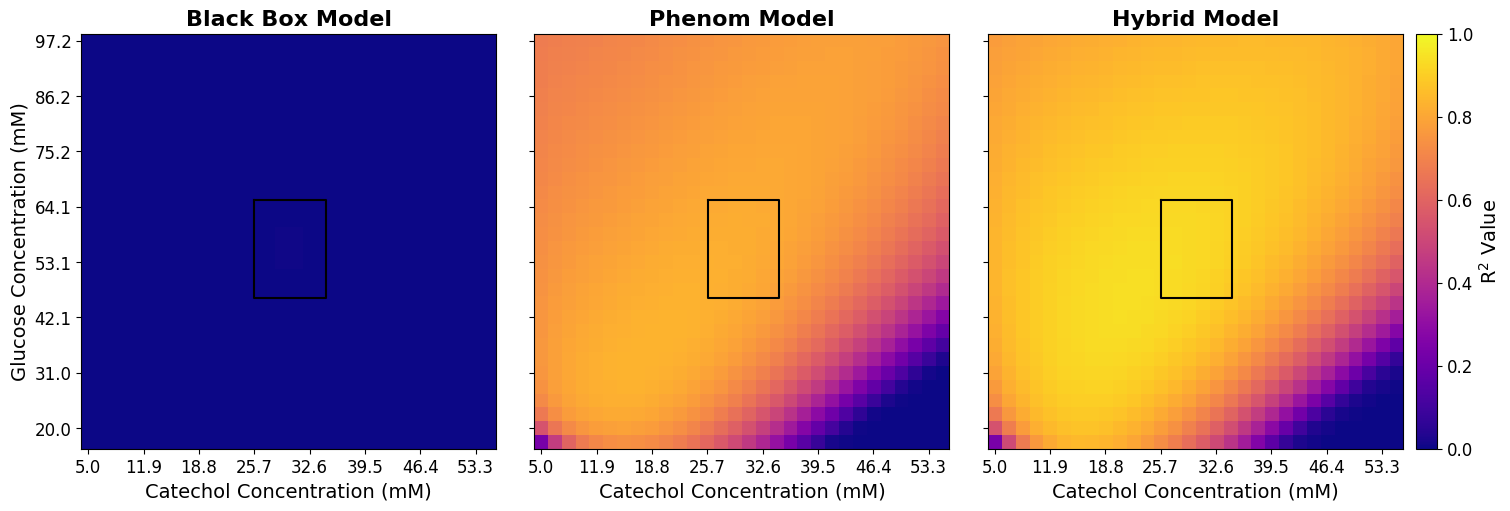

In [46]:
cmap = "plasma"
vmin = 0
vmax = 1
titles = titles = {"ML_Extrapolation" : "Black Box Model", "PM_Extrapolation": "Phenom Model", "HMI_Extrapolation" : "Hybrid Model"}
keys = list(titles.keys())

Cg_range = np.linspace(20, 100, 30)
Cc_range = np.linspace(5, 55, 30)

Xv_const = 0.01


# Create a figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(15,5), constrained_layout=True, sharex = True, sharey = True)

for z in range(len(keys)):
    data1 =  np.flipud(final_dict[keys[z]][1].reshape(30,30))

    # Create heatmaps
    im1 = axes[z].imshow(data1, cmap= cmap, vmin=vmin, vmax=vmax)
    x_label = []
    for i in Cc_range[::4]:
        x_label.append(round(i,1))
    y_label = []
    for i in np.flipud(Cg_range[::4]):
        y_label.append(round(i,1))
    axes[z].set_xticks(ticks = np.arange(30)[::4], labels = x_label, fontsize = 12)
    axes[z].set_yticks(ticks = np.arange(30)[::4], labels = y_label, fontsize = 12) 
    axes[z].set_xlabel("Catechol Concentration (mM)", fontsize = 14)
    if z == 0:
        axes[z].set_ylabel("Glucose Concentration (mM)", fontsize = 14)
    axes[z].plot([x_min, x_max, x_max, x_min, x_min],[y_min, y_min, y_max, y_max, y_min ],"k")
    axes[z].set_title(titles[keys[z]], fontsize = 16, fontweight = "bold")


    # Add a common color bar
imz = im2
cbar = fig.colorbar(imz, ax=axes, orientation='vertical', fraction=0.07, pad=0.01)
cbar.set_label('R$^2$ Value', fontsize = 14)
cbar.ax.tick_params(labelsize = 12)
plt.savefig("HiMa_hpb.svg")

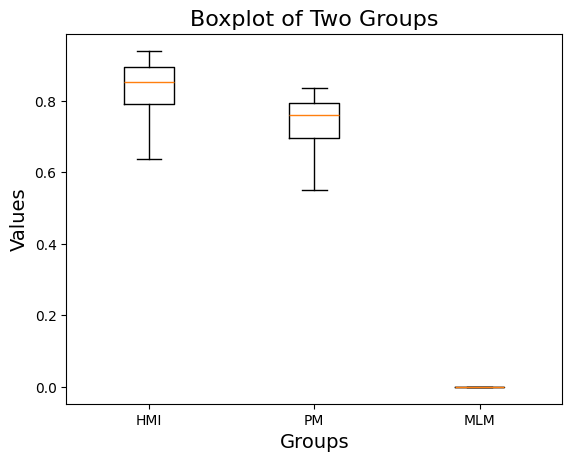

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data for two groups
data1 = final_dict["HMI_Extrapolation"][1]  # Group 1 data
data2 = final_dict["PM_Extrapolation"][1]
data3 = final_dict["ML_Extrapolation"][1]# Group 2 data

# Combine data into a list for plotting
data = [data1, data2, data3]

# Create the boxplot
#plt.figure(figsize=(8, 6))  # Set figure size
plt.boxplot(data, labels=['HMI', 'PM', "MLM"], showfliers = False)  # Add labels for the x-axis

# Add axis labels
plt.xlabel('Groups', fontsize=14)
plt.ylabel('Values', fontsize=14)

# Add a title (optional)
plt.title('Boxplot of Two Groups', fontsize=16)

# Show the plot
plt.show()


Text(0.5, 1.0, 'Phenom Model')

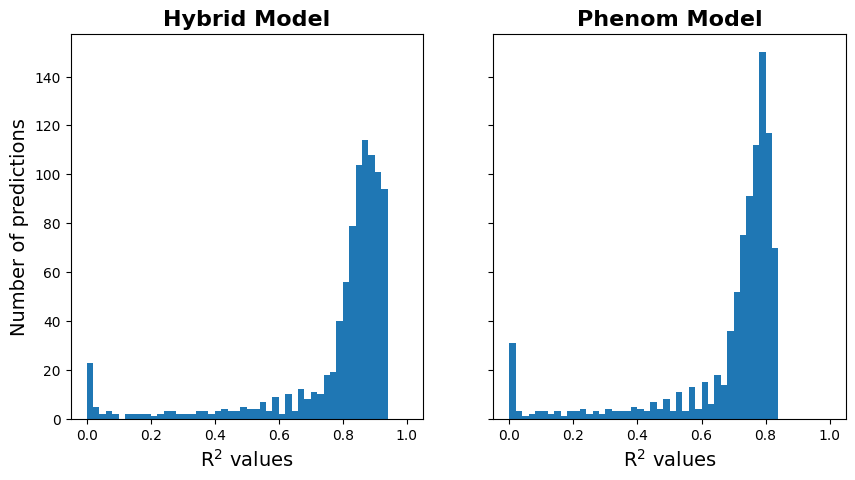

In [48]:
fig, axs = plt.subplots(1,2, figsize = (10,5), sharex = True, sharey = True)
ax = axs.ravel()
n = 51

ax[0].hist(data1, bins = np.linspace(0,1,n))
ax[0].set_xlabel("R$^2$ values", fontsize = 14)
ax[0].set_title("Hybrid Model", fontweight = "bold", fontsize = 16)
ax[0].set_ylabel("Number of predictions", fontsize = 14)

ax[1].hist(data2, bins = np.linspace(0,1,n))
ax[1].set_xlabel("R$^2$ values", fontsize = 14)
ax[1].set_title("Phenom Model", fontweight = "bold", fontsize = 16)